In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import csv
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.init as init
import random

## Initial setup

In [2]:
sns.set()

In [3]:
os.chdir('/zfs/projects/darc/wolee_edehaan_suzienoh-exploratory-ml')

In [4]:
# Declare global variables
global con_list
global dum_list
global deps
global header

In [5]:
# List of continuous variables
con_list = ['absacc', 'acc', 'aeavol', 'age', 'agr', 'baspread', 'beta', 
            'betasq', 'bm', 'bm_ia', 'cash', 'cashdebt', 'cashpr','cfp', 
            'cfp_ia', 'chatoia', 'chcsho', 'chempia', 'chfeps', 'chinv', 
            'chmom', 'chnanalyst', 'chpmia', 'chtx', 'cinvest', 'currat', 
            'depr', 'disp', 'dolvol', 'dy', 'ear', 'egr', 'ep', 'fgr5yr', 
            'gma', 'grcapx', 'grltnoa', 'herf', 'hire', 'idiovol', 'ill', 
            'indmom', 'invest', 'lev', 'lgr', 'maxret', 'mom12m', 'mom1m', 
            'mom36m', 'mom6m', 'ms', 'mve', 'mve_ia', 'nanalyst', 'nincr', 
            'operprof', 'orgcap', 'pchcapx_ia', 'pchcurrat', 'pchdepr', 
            'pchgm_pchsale', 'pchquick', 'pchsale_pchinvt', 'pchsale_pchrect', 
            'pchsale_pchxsga', 'pchsaleinv', 'pctacc', 'pricedelay', 'ps', 
            'quick', 'rd_mve', 'rd_sale', 'realestate', 'retvol', 'roaq', 
            'roavol', 'roeq', 'roic', 'rsup', 'salecash', 'saleinv', 
            'salerec', 'secured', 'sfe', 'sgr', 'sp', 'std_dolvol', 
            'std_turn', 'stdacc', 'stdcf', 'sue', 'tang', 'tb', 'turn', 
            'zerotrade']


# List of dummy variables
dum_list = ['convind', 'divi', 'divo', 'ipo', 'rd', 'securedind', 'sin'] # Categorical variable binary 

# List of dependent variable
deps = con_list + dum_list +['date']

# Headers
header = ['permno','pyear']

## Load and preprocess data

In [6]:
def load_and_preprocess_data(file_path, period):
    
    """
    Loads and preprocesses the input data.

    Args:
    file_path (str): The path to the CSV file to be loaded.

    Returns:
    DataFrame: Preprocessed pandas DataFrame.
    """
    
    # Load data
    df = pd.read_csv(file_path)
    df.columns = [e.lower() for e in df.columns]
    
    df['date'] = df['date'].copy()
    df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
    # df['date'] = df['date'].dt.strftime('%m-%d-%Y')

    # Extract year
    df['pyear'] = df['date'].dt.year
    # Remove months if quarterly, otherwise, monthly, keep all months
    if period == 'quarter':
        df = df[df['date'].dt.month.isin([1,4,7,10])]

    # df.sort_values(['permno','date'], inplace=True)
    df.sort_values(['date', 'permno'], inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m')
    del df['fpedats']
    
    print(df[['date', 'permno']].head())
    print('-' * 50)
        
    return df

In [7]:
class CustomWinsorizer(BaseEstimator, TransformerMixin):
    
    """
    A custom transformer for Winsorizing numeric data.

    Attributes:
    lower_percentile (int): The lower percentile for clipping data.
    upper_percentile (int): The upper percentile for clipping data.
    """
    
    def __init__(self, lower_percentile, upper_percentile):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile

    def fit(self, X, y=None):
        self.lower_bound_ = np.percentile(X, self.lower_percentile)
        self.upper_bound_ = np.percentile(X, self.upper_percentile)
        return self

    def transform(self, X):
        X_clipped = np.clip(X, self.lower_bound_, self.upper_bound_)
        
        return X_clipped

In [8]:
class timePeriodMeanTransformer(BaseEstimator, TransformerMixin):
    
    """
    A custom transformer for imputing missing data based on time period means.

    Attributes:
    date_column (str): The column name representing dates.
    numeric_columns (list): List of numeric column names for which means are calculated.
    period (str): The time period for grouping data, either 'quarter' or 'month'.
    """
    
    def __init__(self, date_column, numeric_columns, period='quarter'):
        self.date_column = date_column
        self.numeric_columns = numeric_columns
        self.period = period

    def fit(self, X, y=None):
        X[self.date_column] = pd.to_datetime(X[self.date_column])
        if self.period == 'quarter':
            X['Period'] = X[self.date_column].dt.quarter
        elif self.period == 'month':
            X['Period'] = X[self.date_column].dt.month
        else:
            raise ValueError("period must be 'quarter' or 'month'")
       
       # Calculate and store the means of each numeric column for each time period
        self.period_means_ = X.groupby('Period')[self.numeric_columns].mean()
        return self

    def transform(self, X):
        X[self.date_column] = pd.to_datetime(X[self.date_column])
        if self.period == 'quarter':
            X['Period'] = X[self.date_column].dt.quarter
        elif self.period == 'month':
            X['Period'] = X[self.date_column].dt.month
        
        for col in self.numeric_columns:
            X[col] = X.apply(lambda row: row[col] if not pd.isna(row[col]) 
                             else self.period_means_.loc[row['Period'], col], axis=1)
        # return X.drop(['Period'], axis=1)
        return X

In [9]:
def build_pipeline(con_list, dum_list, lower_percentile, upper_percentile, period):
    
    """
    Builds a preprocessing pipeline for both numeric and categorical data.

    Args:
    con_list (list): List of continuous variable names.
    dum_list (list): List of dummy (categorical) variable names.
    lower_percentile (float): Lower percentile for winsorization.
    upper_percentile (float): Upper percentile for winsorization.
    period (string): Period for getting mean values (month vs quarter)

    Returns:
    Pipeline: A composed preprocessing pipeline.
    """
    
    numeric_pipeline = Pipeline([
        # ('fill_na', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
        ('winsorizer', CustomWinsorizer(lower_percentile=lower_percentile, upper_percentile=upper_percentile)),
        ('scaler', StandardScaler()),
        ('impute_con', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0))
    ])

    categorical_pipeline = Pipeline([
        ('impute_cat', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ])

    preprocessing = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, con_list),
            ('cat', categorical_pipeline, dum_list)
        ], remainder='passthrough')

    pipeline = Pipeline([
        ('Time_period_mean_imputation', timePeriodMeanTransformer('date', con_list, period)),
        ('Preprocessing', preprocessing),
    ])
    
    return pipeline

In [10]:
infile_path = 'Info Processing and Mutual Funds/masterv14.csv'
period = 'month'

In [11]:
if period == 'quarter':
    target = 'retq'
elif period == 'month':
    target = 'ret'
else:
    raise ValueError("period must be 'quarter' or 'month'")

In [12]:
# Load and preprocess data
print('\nLoading and preprocessing data...\n')
df = load_and_preprocess_data(infile_path, period)


Loading and preprocessing data...

      date  permno
0  1980-01   10006
1  1980-01   10057
2  1980-01   10103
3  1980-01   10137
4  1980-01   10145
--------------------------------------------------


In [13]:
# Drop null values in the target column and get years 2020 or prior
df1 = df.dropna(subset=[target])
df1 = df1[df1['pyear'] <= 2020]
df1.reset_index(drop=True, inplace=True)

In [14]:
df1

,permno,gvkey,adatadate,fyear,sic2,spi,mve_f,bm,ep,cashpr,...,std_dolvol,std_turn,ill,zerotrade,beta,betasq,rsq1,pricedelay,idiovol,pyear
0,10006,1010,12/31/1978,1978,37,0.0000,269.308500,1.180962,0.153022,-32.218678,...,0.881844,0.635898,2.565667e-08,1.115306e-07,1.060420,1.124491,0.343408,0.029859,0.025576,1980
1,10057,1098,09/30/1978,1978,36,0.0000,97.372000,0.956692,0.135131,-4.408581,...,1.368363,2.546787,2.719812e-07,6.199128e-08,1.526013,2.328716,0.307905,0.092667,0.037473,1980
2,10103,1012,10/31/1978,1978,33,NaN,1.697500,3.362003,0.338144,-17.143817,...,NaN,NaN,NaN,NaN,1.759493,3.095816,0.096753,0.221851,0.087020,1980
3,10137,1279,12/31/1978,1978,49,NaN,537.524500,1.330341,0.153238,-87.819837,...,0.553246,0.740017,1.765620e-08,9.726790e-08,0.492885,0.242936,0.189693,0.125777,0.017540,1980
4,10145,1300,12/31/1978,1978,99,-0.0031,805.633282,1.579284,0.149248,-22.050470,...,0.427617,0.657563,2.898901e-09,6.190654e-08,1.139163,1.297691,0.279437,0.024228,0.031201,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165510,93422,154357,12/31/2019,2019,13,-0.0090,1069.650000,2.487356,-0.090964,-14.117559,...,0.797001,12.233361,7.505129e-09,5.571619e-09,2.691027,7.241625,0.265207,0.257939,0.132692,2020
2165511,93423,10567,12/31/2019,2019,79,0.0004,3817.839740,-0.187572,0.046902,19.464647,...,0.519033,17.649093,4.462048e-10,3.803709e-09,1.921529,3.692274,0.485215,0.068369,0.061119,2020
2165512,93426,185138,12/31/2019,2019,36,-0.0108,459.782000,0.524944,0.048258,1.095352,...,0.473367,2.144264,2.296462e-08,3.236729e-08,1.302016,1.695247,0.472220,0.037482,0.043174,2020
2165513,93434,184259,06/30/2019,2019,1,-0.1349,87.853920,1.138777,-0.105914,-13.505851,...,0.935967,0.897075,3.435272e-07,1.037670e-07,0.389842,0.151977,0.021429,-0.694649,0.073887,2020


In [15]:
sample = df1.loc[df1['permno']==10103]

In [16]:
sample[['permno', 'date']]

,permno,date
2,10103,1980-01
3462,10103,1980-02
6932,10103,1980-03
10441,10103,1980-04
13941,10103,1980-05
...,...,...
479711,10103,1989-07
484311,10103,1989-08
488942,10103,1989-09
493659,10103,1989-10


## Transform data

In [17]:
print('Training in progress...\n')
# Build a training pipeline
pipeline = build_pipeline(con_list, dum_list, 5, 95, period)

Training in progress...



In [18]:
pipeline

Pipeline(steps=[('Time_period_mean_imputation',
                 timePeriodMeanTransformer(date_column='date',
                                           numeric_columns=['absacc', 'acc',
                                                            'aeavol', 'age',
                                                            'agr', 'baspread',
                                                            'beta', 'betasq',
                                                            'bm', 'bm_ia',
                                                            'cash', 'cashdebt',
                                                            'cashpr', 'cfp',
                                                            'cfp_ia', 'chatoia',
                                                            'chcsho', 'chempia',
                                                            'chfeps', 'chinv',
                                                            'chmom',
                                                            'chnanalyst',
                                                            'chpmia', 'chtx',
                                                            'cinvest', 'currat',
                                                            'depr', 'disp',
                                                            'dolvol...
                                                   'beta', 'betasq', 'bm',
                                                   'bm_ia', 'cash', 'cashdebt',
                                                   'cashpr', 'cfp', 'cfp_ia',
                                                   'chatoia', 'chcsho',
                                                   'chempia', 'chfeps', 'chinv',
                                                   'chmom', 'chnanalyst',
                                                   'chpmia', 'chtx', 'cinvest',
                                                   'currat', 'depr', 'disp',
                                                   'dolvol', 'dy', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['convind', 'divi', 'divo',
                                                   'ipo', 'rd', 'securedind',
                                                   'sin'])]))])

In [19]:
# Set year range of the sample
years = list(sample['pyear'].drop_duplicates().sort_values())

In [20]:
years

[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989]

In [21]:
year = 1986

In [22]:
train_data = sample.loc[(sample['pyear']<=year)]
test_data = sample.loc[(sample['pyear']==year+1)]

In [23]:
# Training and testing data
training_years = sorted(train_data.pyear.unique())
print(f'Training Years: {training_years}\n')
print(f'Testing Year: {test_data.pyear.unique()}')

Training Years: [1980, 1981, 1982, 1983, 1984, 1985, 1986]

Testing Year: [1987]


In [24]:
train_data

,permno,gvkey,adatadate,fyear,sic2,spi,mve_f,bm,ep,cashpr,...,std_dolvol,std_turn,ill,zerotrade,beta,betasq,rsq1,pricedelay,idiovol,pyear
2,10103,1012,10/31/1978,1978,33,NaN,1.697500,3.362003,0.338144,-17.143817,...,NaN,NaN,NaN,NaN,1.759493,3.095816,0.096753,0.221851,0.087020,1980
3462,10103,1012,10/31/1978,1978,33,NaN,1.697500,3.362003,0.338144,-17.143817,...,NaN,NaN,NaN,NaN,1.736435,3.015207,0.088872,0.124053,0.090373,1980
6932,10103,1012,10/31/1978,1978,33,NaN,1.697500,3.362003,0.338144,-17.143817,...,NaN,NaN,NaN,NaN,1.546370,2.391259,0.065518,-0.026851,0.096490,1980
10441,10103,1012,10/31/1978,1978,33,NaN,1.697500,3.362003,0.338144,-17.143817,...,NaN,NaN,NaN,NaN,1.544397,2.385163,0.065431,0.024635,0.096057,1980
13941,10103,1012,10/31/1979,1979,33,-0.0537,1.196125,3.833059,-0.434737,-40.641964,...,NaN,NaN,NaN,NaN,1.353537,1.832062,0.069685,-0.237500,0.097406,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319599,10103,1012,10/31/1985,1985,33,-0.0306,3.654000,2.275041,0.173508,-20.234694,...,0.970630,0.430200,4.102243e-06,12.409091,0.255926,0.065498,-0.004113,0.565691,0.070953,1986
324006,10103,1012,10/31/1985,1985,33,-0.0306,3.654000,2.275041,0.173508,-20.234694,...,0.693619,0.102686,4.734849e-06,13.000002,0.295377,0.087248,-0.003160,0.761472,0.071049,1986
328503,10103,1012,10/31/1985,1985,33,-0.0306,3.654000,2.275041,0.173508,-20.234694,...,1.260025,0.589355,6.410256e-07,16.000000,0.311741,0.097183,-0.002642,0.756879,0.070830,1986
332973,10103,1012,10/31/1985,1985,33,-0.0306,3.654000,2.275041,0.173508,-20.234694,...,0.575778,0.242380,5.204745e-06,15.521740,0.402515,0.162018,0.000413,1.071883,0.070324,1986


In [25]:
test_data

,permno,gvkey,adatadate,fyear,sic2,spi,mve_f,bm,ep,cashpr,...,std_dolvol,std_turn,ill,zerotrade,beta,betasq,rsq1,pricedelay,idiovol,pyear
341802,10103,1012,10/31/1985,1985,33,-0.0306,3.65400,2.275041,0.173508,-20.234694,...,1.231006,1.800102,1.090449e-06,10.500000,0.361593,0.130749,-0.000917,0.742484,0.069696,1987
346169,10103,1012,10/31/1985,1985,33,-0.0306,3.65400,2.275041,0.173508,-20.234694,...,1.335870,1.067087,2.457757e-06,14.000000,0.416393,0.173383,0.000707,0.478180,0.069820,1987
350559,10103,1012,10/31/1985,1985,33,-0.0306,3.65400,2.275041,0.173508,-20.234694,...,1.151043,0.556207,1.305952e-06,7.736842,0.441242,0.194694,0.002159,0.686020,0.069377,1987
354962,10103,1012,10/31/1985,1985,33,-0.0306,3.65400,2.275041,0.173508,-20.234694,...,1.176656,2.029221,3.228941e-06,10.500000,0.455675,0.207640,0.002806,0.675348,0.069471,1987
359356,10103,1012,10/31/1986,1986,33,0.0000,4.71975,1.851793,0.090471,-13.191343,...,1.617956,0.744302,4.896825e-06,10.000000,0.552083,0.304795,0.005441,0.690085,0.073579,1987
363768,10103,1012,10/31/1986,1986,33,0.0000,4.71975,1.851793,0.090471,-13.191343,...,0.961905,0.416399,5.807201e-06,16.800001,0.593509,0.352253,0.006986,0.674006,0.073664,1987
368195,10103,1012,10/31/1986,1986,33,0.0000,4.71975,1.851793,0.090471,-13.191343,...,1.292959,0.536874,1.681607e-06,12.409091,0.602111,0.362537,0.007328,0.595316,0.073786,1987
372635,10103,1012,10/31/1986,1986,33,0.0000,4.71975,1.851793,0.090471,-13.191343,...,1.939971,0.857289,5.997901e-07,12.409091,0.585699,0.343043,0.006230,0.712869,0.073638,1987
377143,10103,1012,10/31/1986,1986,33,0.0000,4.71975,1.851793,0.090471,-13.191343,...,0.959727,0.384731,0.000000e+00,15.000001,0.619795,0.384145,0.006747,0.683746,0.073250,1987
381798,10103,1012,10/31/1986,1986,33,0.0000,4.71975,1.851793,0.090471,-13.191343,...,1.514816,0.988957,0.000000e+00,13.000000,0.611251,0.373628,0.006330,0.715021,0.073300,1987


In [26]:
def transform_data(train_data, test_data, features, target, pipeline):
    # Train data
    x_train = train_data.loc[:, features]
    y_train = train_data.loc[:, target]
    
    # Fit the pipeline to the train data
    pipeline.fit(x_train)
    x_train_tf = pipeline.transform(x_train)
    x_train_tf = x_train_tf[:, :-2]
    
    # Test data
    x_test = test_data.loc[:, features]
    y_test = test_data.loc[:, target]
    
    # Fit the pipeline to the test data
    x_test_tf = pipeline.transform(x_test)
    x_test_tf = x_test_tf[:, :-2]
    
    # Transform data into numpy array as type float32
    x_train_tf = x_train_tf.astype(np.float32)
    y_train_tf = y_train.to_numpy(np.float32)
    x_test_tf = x_test_tf.astype(np.float32)
    y_test_tf = y_test.to_numpy(np.float32)
    
    # # Transform them to tensor floats
    x_train_tf = torch.tensor(x_train_tf).float()
    y_train_tf = torch.tensor(y_train_tf).float()
    x_test_tf = torch.tensor(x_test_tf).float()
    y_test_tf = torch.tensor(y_test_tf).float()

    print(f'x_train shape: {x_train_tf.shape}')
    print(f'y_train shape: {y_train_tf.shape}\n')
    print(f'x_test shape: {x_test_tf.shape}')
    print(f'y_test shape: {y_test_tf.shape}\n')
    
    return x_train_tf, y_train_tf, x_test_tf, y_test_tf
    

In [27]:
x_train, y_train, x_test, y_test = transform_data(train_data, test_data, deps, target, pipeline)

x_train shape: torch.Size([84, 102])
y_train shape: torch.Size([84])

x_test shape: torch.Size([12, 102])
y_test shape: torch.Size([12])



/zfs/projects/darc/wolee_edehaan_suzienoh-exploratory-ml/kevin/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1140: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/zfs/projects/darc/wolee_edehaan_suzienoh-exploratory-ml/kevin/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1145: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/zfs/projects/darc/wolee_edehaan_suzienoh-exploratory-ml/kevin/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1165: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


## Finalize sequence data for LSTM

In [28]:
# pipeline inside Dataset
class SequenceDataset(Dataset):
    def __init__(self, train_data, test_data, features, target, pipeline, sequence_length=5):
        self.train_data = train_data
        self.test_data = test_data
        self.features = features
        self.target = target
        self.pipeline = pipeline
        self.sequence_length = sequence_length
        self.x_train, self.y_train, self.x_test, self.y_test = self._transform_data()
        
    def _transform_data(self):
        """
        Transform the data using provided pipeline
        """
        x_train = self.train_data.loc[:, self.features]
        y_train = self.train_data.loc[:, self.target]
        
        # Fit the pipeline to the training data
        self.pipeline.fit(x_train)
        x_train = self.pipeline.transform(x_train)
        x_train = x_train[:, :-2]
        
        x_test = self.test_data.loc[:, self.features] 
        y_test = self.test_data.loc[:, self.target]
        
        # Fit the pipeline to the testing data  
        x_test = self.pipeline.transform(x_test)
        x_test = x_test[:, :-2]
        
        # Transform data into numpy array as type float32
        x_train = x_train.astype(np.float32)
        y_train = y_train.to_numpy(np.float32)
        x_test = x_test.astype(np.float32)
        y_test = y_test.to_numpy(np.float32)
        
        # # Transform them to tensor floats
        x_train = torch.tensor(x_train).float()
        y_train = torch.tensor(y_train).float()
        x_test = torch.tensor(x_test).float()
        y_test = torch.tensor(y_test).float()
        
        print(f'x_train shape: {x_train.shape}')
        print(f'y_train shape: {y_train.shape}\n')
        print(f'x_test shape: {x_test.shape}')
        print(f'y_test shape: {y_test.shape}\n')
        
        return x_train, y_train, x_test, y_test
        
    def __len__(self):
        return max(self.x_train.shape[0], self.x_test.shape[0])

    def __getitem__(self, i):
        """
        Return the corresponding ith data for all x_train, y_train, x_test, y_test
        """
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x_train = self.x_train[i_start:(i + 1), :]
            x_test = self.x_test[i_start:(i+1), :]
        else:
            # repeat the first row as many times to make up the gap
            train_padding = self.x_train[0].repeat(self.sequence_length - i - 1, 1)
            test_padding = self.x_test[0].repeat(self.sequence_length - i - 1, 1)
            # concatenate the padding with the available rows
            x_train = self.x_train[0:(i + 1), :]
            x_train = torch.cat((train_padding, x_train), 0)
            x_test = self.x_test[0:(i+1), :]
            x_test = torch.cat((test_padding, x_test), 0)
            
        # Since train and test have different length, return None when index i exceeds max length
        if i >= self.y_train.shape[0]:
            x_train = None
            y_train = None
            pass
        else:
            y_train = self.y_train[i]
            # print(f'x_train ith item shape: {x_train.shape}')
            # print(f'y_train: {y_train}')
            
        if i >= self.y_test.shape[0]:
            x_test = None
            y_test = None
            pass
        else:
            y_test = self.y_test[i]
            # print(f'x_test ith item shape: {x_test.shape}')
            # print(f'y_test: {y_test}')

        return x_train, y_train, x_test, y_test

In [29]:
# pipeline outside Dataset
class SequenceDataset(Dataset):
    def __init__(self, x, y, sequence_length=5):
        self.x = x
        self.y = y
        self.sequence_length = sequence_length
        self.ith_x = None
        
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        """
        Return the corresponding ith data for x and y
        """
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            self.ith_x = self.x[i_start:(i + 1), :]
        else:
            # repeat the first row as many times to make up the gap
            data_padding = self.x[0].repeat(self.sequence_length - i - 1, 1)
            # concatenate the padding with the available rows
            self.ith_x = self.x[0:(i + 1), :]
            self.ith_x = torch.cat((data_padding, self.ith_x), 0)
        
        # print(f'x ith item shape: {self.ith_x.shape}')
        # print(f'y : {self.y[i]}')
            
        return self.ith_x, self.y[i]

In [30]:
train_dataset = SequenceDataset(x_train, y_train, sequence_length=3)

In [31]:
len(train_dataset)

84

In [32]:
train_dataset[15]

(tensor([[ 0.7499,  0.6793,  0.0000, -1.2978, -0.8048,  0.5358,  0.8377,  0.7715,
           1.5869,  1.3162,  0.0000, -1.4420, -1.4628, -1.1093,  0.3620, -0.0222,
           1.0113, -2.2560,  0.0000,  0.0262,  0.9260,  0.0000, -0.7407,  0.0000,
           0.0000, -0.3796,  1.4237,  0.0000, -0.7733,  0.0000,  0.0000, -1.4784,
          -2.2394,  0.0000, -0.3324,  0.1686, -1.6917,  1.1095, -2.0936,  0.6953,
          -0.6628, -0.1735, -1.9973,  0.8968, -0.1511,  1.2059, -2.0602,  1.2980,
          -0.1774, -0.8898,  0.0000, -1.6296,  0.7597,  0.0000,  0.0000, -0.8128,
           1.0980, -1.3131,  1.5445,  2.1129, -0.4312,  1.3736, -0.1862, -1.6223,
          -0.7674, -0.3479,  0.1157, -0.4810, -0.7717, -0.7289,  0.3529,  0.2666,
           1.0377,  1.6535,  0.0000,  0.0000,  0.0000, -0.4560,  0.0000,  1.3541,
          -1.2003, -1.1821, -0.1696,  0.0000, -0.4491,  1.1873,  0.7483, -0.0803,
           0.0000,  0.0000,  0.0000, -1.7919,  0.8007, -0.4960,  1.3358,  0.0000,
           0.000

In [33]:
test_dataset = SequenceDataset(x_test, y_test, sequence_length=3)

In [34]:
len(test_dataset)

12

In [35]:
test_dataset[11]

(tensor([[-0.7790, -0.2882,  0.0000,  2.1089,  0.1867, -1.0176, -0.5996, -0.7500,
          -1.9747, -1.6214,  0.0000,  0.0761,  0.3986,  0.3700,  0.4044, -0.5454,
           0.7151, -0.1158,  0.0000, -0.6152, -1.3226,  0.0000, -0.5243,  0.0000,
           0.0000, -0.5307,  1.1604,  0.0000, -0.5064,  0.0000,  0.0000, -0.0720,
          -0.0295,  0.0000,  0.0864, -0.3712,  0.5588, -0.8454, -0.1136, -0.7839,
          -1.0359,  1.8623,  0.1328, -2.1055,  0.2256, -0.8526, -0.1731, -0.1566,
           0.6422, -1.1562,  0.0000,  1.7011, -0.7639,  0.0000,  0.0000,  0.1290,
          -0.7314,  2.8559, -0.8237, -0.7052, -0.4837, -0.3193,  0.2166, -1.3962,
          -1.0295,  0.0364,  0.2109,  0.5669, -1.3720, -0.1979, -2.3064, -1.0309,
           3.7404, -1.1598,  0.0000,  0.0000,  0.0000, -0.0262,  0.0000, -0.0964,
           1.2174, -0.7592,  1.1483,  0.0000, -0.8033, -1.9130,  0.9559,  0.1062,
           0.0000,  0.0000,  0.0000,  0.6131,  0.3906, -0.6011,  0.3920,  0.0000,
           0.000

In [36]:
# dataset = SequenceDataset(train_data, test_data, deps, target, pipeline, 3)

In [37]:
# dataset[11]

In [38]:
torch.manual_seed(42)
batch_size = 12
sequence_length = 3

In [39]:
train_dataset = SequenceDataset(x_train, y_train, sequence_length=sequence_length)
test_dataset = SequenceDataset(x_test, y_test, sequence_length=sequence_length)

In [40]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
X, y = next(iter(train_loader))

In [42]:
print(X.shape, y.shape)

torch.Size([12, 3, 102]) torch.Size([12])


## Modeling data with LSTM

In [43]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [44]:
class RegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, num_layers=2, lstm_dropout=0, dropout=0.2):
        super(RegressionLSTM, self).__init__()
        self.num_sensors = num_sensors
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.lstm_dropout = lstm_dropout

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            num_layers=num_layers,
            batch_first=True,
            dropout=self.lstm_dropout,
        )

        self.linear = nn.Linear(in_features=hidden_units, out_features=1)
        self.dropout = nn.Dropout(p=dropout)
        # self.batch_norm = nn.BatchNorm1d(hidden_units)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.empty(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.empty(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        init.xavier_normal_(h0)
        init.xavier_normal_(c0)
        
        lstm_out, (hn, _) = self.lstm(x, (h0, c0))
        hn = hn[-1]  # Take the output of the last LSTM layer

        # hn = self.batch_norm(hn)
        out = self.linear(self.dropout(hn)).flatten()

        return out

In [45]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    # print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    # print(f"Test loss: {avg_loss}")

In [46]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set the seed for reproducibility
set_seed(42)

In [66]:
learning_rate = 1e-4
num_hidden_units = 30
num_features = x_train.shape[1]

# model = ShallowRegressionLSTM(num_sensors=num_features, hidden_units=num_hidden_units)
model = RegressionLSTM(num_sensors=num_features, hidden_units=num_hidden_units, num_layers=2, lstm_dropout=0.1, dropout=0.1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [67]:
print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(100):
    # print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)


Untrained test
--------



In [68]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [69]:
train_data_final = train_data.copy()
test_data_final = test_data.copy()

In [70]:
train_data_final['pred'] = predict(train_loader, model).numpy()

In [71]:
test_data_final['pred'] = predict(test_loader, model).numpy()

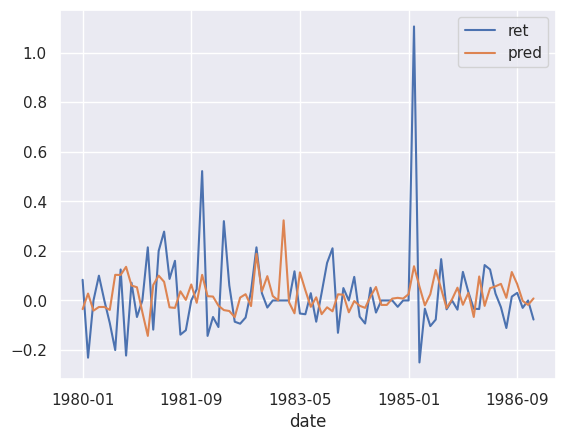

In [72]:
train_data_final[['date', target, 'pred']].set_index('date').plot();

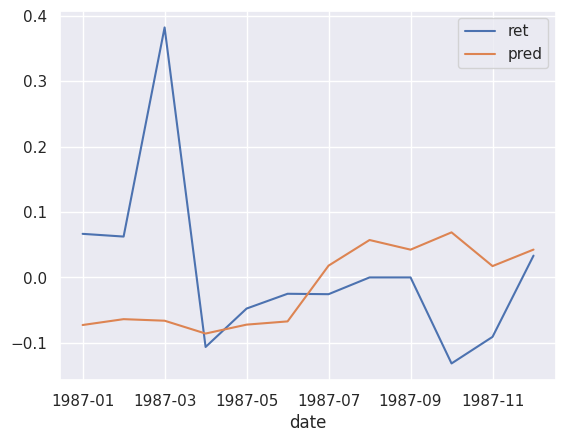

In [73]:
test_data_final[['date', target, 'pred']].set_index('date').plot();

In [74]:
mean_absolute_error(train_data_final[target], train_data_final['pred'])

0.11570481995762817

In [75]:
mean_absolute_error(test_data_final[target], test_data_final['pred'])

0.10525740788519383

## Scale this up to many companies

In [57]:
permnos = df1['permno'].sample(10, random_state=42).to_list()

In [58]:
permnos

[11308, 57891, 31481, 36695, 82747, 18973, 15667, 52039, 77785, 82851]

In [59]:
sample2 = df1.loc[df1['permno'].isin(permnos)]

In [60]:
sample2

,permno,gvkey,adatadate,fyear,sic2,spi,mve_f,bm,ep,cashpr,...,std_dolvol,std_turn,ill,zerotrade,beta,betasq,rsq1,pricedelay,idiovol,pyear
62,11308,3144,12/31/1978,1978,20,0.0000,5419.612673,0.320984,0.069136,8.871277,...,0.579809,0.418106,3.221865e-09,1.362653e-07,0.744968,0.554978,0.261126,0.236456,0.020792,1980
227,15667,1478,12/31/1978,1978,28,0.0000,4401.787500,0.267451,0.079155,5.824822,...,0.404813,0.359411,2.576623e-09,1.244805e-07,0.646080,0.417419,0.178905,0.423660,0.021309,1980
1294,36695,9940,12/31/1978,1978,50,0.0000,5.295620,1.227618,0.121610,-0.631990,...,0.983171,0.979961,4.144208e-06,3.150000e+00,1.838416,3.379772,0.102686,-0.026567,0.088525,1980
2269,52039,7137,05/31/1979,1978,13,0.0000,41.985875,0.236984,0.037751,7.644350,...,NaN,NaN,NaN,NaN,1.220223,1.488943,0.109311,0.001918,0.060128,1980
3521,11308,3144,12/31/1978,1978,20,0.0000,5419.612673,0.320984,0.069136,8.871277,...,0.645116,0.805385,3.064770e-09,6.958172e-08,0.774937,0.600527,0.271350,0.192087,0.021260,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161200,82747,61766,06/30/2019,2019,38,0.0000,14.437500,0.187567,-0.521835,6.766688,...,2.263128,814.075660,6.812967e-08,8.403467e-11,2.483512,6.167833,0.085502,0.686549,0.221275,2020
2162232,11308,3144,12/31/2019,2019,20,0.0001,236898.000000,0.080123,0.037653,16.030783,...,0.409500,2.001703,1.183236e-11,2.770234e-08,0.790013,0.624120,0.524392,0.029811,0.023643,2020
2163602,18973,2352,07/31/2019,2019,39,NaN,2741.534810,0.310328,0.047878,5.676767,...,0.406268,1.765895,2.034895e-09,2.066193e-08,0.965152,0.931518,0.507810,0.072882,0.029118,2020
2164297,77785,25572,12/31/2019,2019,33,0.0000,1200.348800,0.649058,0.048427,NaN,...,0.422844,2.025592,3.056281e-09,2.251303e-08,0.997562,0.995130,0.486198,0.009483,0.032615,2020


In [61]:
# Set year range of the sample
years = list(sample2['pyear'].drop_duplicates().sort_values())

In [62]:
years

[1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020]

In [76]:
# companies have different years of data
pd.pivot_table(index='date', columns='permno', data=sample2, values='pyear', aggfunc='count')

permno,11308,15667,18973,31481,36695,52039,57891,77785,82747,82851
date,,,,,,,,,,
1980-01,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
1980-02,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
1980-03,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
1980-04,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
1980-05,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-08,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN
2020-09,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN
2020-10,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN


In [77]:
companies = sample2.groupby('permno')

In [82]:
for _, co in companies:
    print(co.shape)

(492, 158)
(357, 158)
(429, 158)
(51, 158)
(278, 158)
(264, 158)
(142, 158)
(329, 158)
(286, 158)
(33, 158)
